In [3]:
import matplotlib.pyplot as plt
from cycler import cycler

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
for i in range(len(tableau20)):
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
plt.rc('legend', frameon=True,fancybox=True,fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('grid', linestyle="--", color='grey',alpha = 0.2)
plt.rc('font', size=14, family='sans-serif',style='normal',weight='normal')
plt.rc('axes', labelsize=14, titlesize=14,
       titleweight='bold',prop_cycle=(cycler('color',tableau20)))

plt.rc('figure', figsize=(14, 8),titlesize=16)

In [2]:
import pandas as pd
import numpy as np
import datetime
import os
%matplotlib inline

import matplotlib as mpl
#import seaborn as sns

In [4]:
df = pd.read_pickle(os.path.join('data','quote=FING-BALIV-SDBNCC-BLUMI-SDBNET-BTHULEHM-B&start=2016-10-10&end=2017-10-06&interval=1440min.pkl'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1535 entries, 0 to 1534
Data columns (total 7 columns):
datetime    1535 non-null datetime64[ns]
stock       1535 non-null object
open        1535 non-null float64
high        1535 non-null float64
low         1535 non-null float64
close       1535 non-null float64
volume      1535 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 84.0+ KB


open                                              \
stock               ALIV-SDB FING-B   HM-B LUMI-SDB  NCC-B NET-B   THULE   
datetime                                                                   
2016-10-10 17:30:00    908.0  95.30  246.0    33.73  222.0   NaN  142.50   
2016-10-11 17:30:00    905.0  98.00  251.3    34.39  223.8   NaN  143.50   
2016-10-12 17:30:00    904.5  94.75  250.8    34.42  219.7   NaN  140.50   
2016-10-13 17:30:00    902.0  92.00  254.5    34.53  221.0   NaN  142.25   
2016-10-14 17:30:00    886.5  90.60  256.0    33.91  218.0   NaN  143.00   

                        high                  ...     close                \
stock               ALIV-SDB FING-B   HM-B    ...     NCC-B NET-B   THULE   
datetime                                      ...                           
2016-10-10 17:30:00    914.5   99.1  252.0    ...     223.7   NaN  143.25   
2016-10-11 17:30:00    909.5   98.1  252.7    ...     220.0   NaN  142.00   
2016-10-12 17:30:00    907.0   95.0  257.2    ...     221.9   NaN  142.50   
2016-10-13 17:30:00    902.0   93.2  254.5    ...     222.5   NaN  142.75   
2016-10-14 17:30:00    893.5   91.0  259.3    ...     225.8   NaN  145.00   

                       volume                                             \
stock                ALIV-SDB     FING-B       HM-B   LUMI-SDB     NCC-B   
datetime                                                                   
2016-10-10 17:30:00  169525.0  5475622.0  2928230.0   845902.0  240426.0   
2016-10-11 17:30:00  198259.0  6682251.0  2545826.0  1068753.0  315068.0   
2016-10-12 17:30:00  129675.0  6477604.0  4080455.0  1083221.0  295755.0   
2016-10-13 17:30:00  192733.0  6801763.0  2926937.0   913056.0  214083.0   
2016-10-14 17:30:00  240887.0  5316859.0  3729680.0   696082.0  485440.0   

                                     
stock               NET-B     THULE  
datetime                             
2016-10-10 17:30:00   NaN   41264.0  
2016-10-11 17:30:00   NaN   74840.0  
2016-10-12 17:30:00   NaN   64153.0  
2016-10-13 17:30:00   NaN   33768.0  
2016-10-14 17:30:00   NaN  126133.0  

[5 rows x 35 columns]

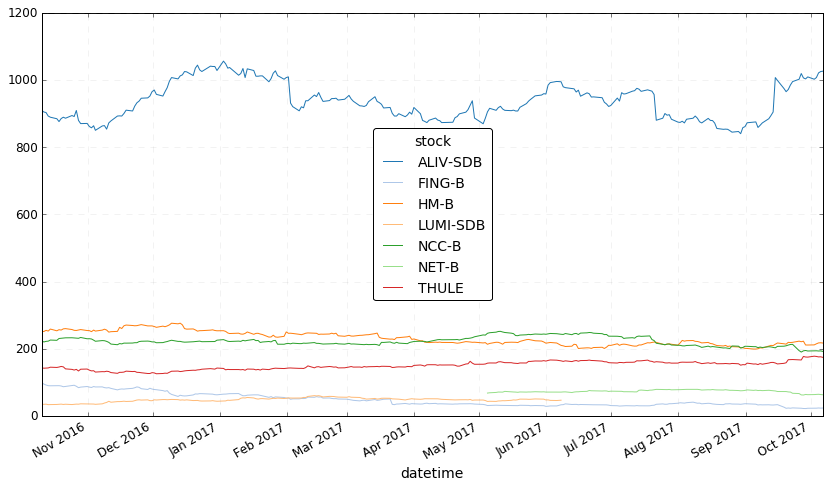

In [103]:
df_stock = df.groupby(['datetime','stock']).sum().unstack()
stocks = df_stock['close'].columns
df_stock['close'].plot(grid=True)
df_stock.head()

In [104]:
# ADD MEASURES

df_stock = df_stock.join(df_stock[['high']].div(df_stock['low'])
                         .sub(1).mul(100).rename(columns={'high':'x-low-high'}))
df_stock = df_stock.join(df_stock[['high']].div(df_stock['open'])
                         .sub(1).mul(100).rename(columns={'high':'x-open-high'}))
# SHIFT SINGLE
# open/close.shift(1) = GAP
# close/close.shift(1) = GAP + DAY CHANGE (WHAT YOU SEE)
df_stock = df_stock.join(df_stock[['open']].div(df_stock['close'].shift(periods=1))
                         .sub(1).mul(100).rename(columns={'open':'x-close-open'}))

for days in np.arange(1,11):
    # look at at days back total change
    df_stock = df_stock.join(df_stock[['open']].div(df_stock['open'].shift(periods=days))
                             .sub(1).mul(100).rename(columns={'open':'x-open-open-days-'+str(days)}))
    # Look at days back daily change
    df_stock = df_stock.join(df_stock[['open']].shift(periods=days-1).div(df_stock['open'].shift(periods=days))
                             .sub(1).mul(100).rename(columns={'open':'x-open-open-day-'+str(days)}))
    
#PREDICTORS, SHIFT BOTH BACK IN TIME, SEE IN FUTURE
#GAP FIRST DAY EXCLUDED SINCE CLOSE PRICE INCLUDED IN X (NO TIME TO TRADE)
# close.shift(-1)/open.shift(1) = NEXT DAY OUTCOME
# close.shift(-days)/open.shift(1) = NEXT X DAYS OUTCOME

for days in np.arange(0,11):
    df_stock = df_stock.join(df_stock[['close']].shift(periods=-days).div(df_stock['open'])
                             .sub(1).mul(100).rename(columns={'close':'y-open-close-days-'+str(days)}))
    
df_stock.head()

open                                              \
stock               ALIV-SDB FING-B   HM-B LUMI-SDB  NCC-B NET-B   THULE   
datetime                                                                   
2016-10-10 17:30:00    908.0  95.30  246.0    33.73  222.0   NaN  142.50   
2016-10-11 17:30:00    905.0  98.00  251.3    34.39  223.8   NaN  143.50   
2016-10-12 17:30:00    904.5  94.75  250.8    34.42  219.7   NaN  140.50   
2016-10-13 17:30:00    902.0  92.00  254.5    34.53  221.0   NaN  142.25   
2016-10-14 17:30:00    886.5  90.60  256.0    33.91  218.0   NaN  143.00   

                        high                  ...    y-open-close-days-9  \
stock               ALIV-SDB FING-B   HM-B    ...                  NCC-B   
datetime                                      ...                          
2016-10-10 17:30:00    914.5   99.1  252.0    ...               4.684685   
2016-10-11 17:30:00    909.5   98.1  252.7    ...               3.932082   
2016-10-12 17:30:00    907.0   95.0  257.2    ...               5.644060   
2016-10-13 17:30:00    902.0   93.2  254.5    ...               4.751131   
2016-10-14 17:30:00    893.5   91.0  259.3    ...               5.963303   

                                    y-open-close-days-10                      \
stock               NET-B     THULE             ALIV-SDB    FING-B      HM-B   
datetime                                                                       
2016-10-10 17:30:00   NaN -1.754386            -1.541850 -5.508919  4.512195   
2016-10-11 17:30:00   NaN -3.484321            -1.546961 -6.836735  1.352965   
2016-10-12 17:30:00   NaN -2.846975             0.497512 -6.807388  1.395534   
2016-10-13 17:30:00   NaN -2.636204            -2.494457 -8.586957  0.432220   
2016-10-14 17:30:00   NaN -6.468531            -1.861252 -5.353201  0.390625   

                                                         
stock                LUMI-SDB     NCC-B NET-B     THULE  
datetime                                                 
2016-10-10 17:30:00  0.237178  4.774775   NaN -2.807018  
2016-10-11 17:30:00  0.378017  3.708668   NaN -4.878049  
2016-10-12 17:30:00  1.975596  5.370960   NaN -1.423488  
2016-10-13 17:30:00  1.071532  4.524887   NaN -5.975395  
2016-10-14 17:30:00  6.163374  7.110092   NaN -2.797203  

[5 rows x 273 columns]

In [221]:

column = 'y-open-close-days-0'
#df_stock = df_stock.join(df_stock[[column]].rename(columns={column:column+'-B'}))
mask = df_stock[[column+'-B']] > 1

mask.replace([True,False],['up','down'])

y-open-close-days-0-B                                    \
stock                            ALIV-SDB FING-B  HM-B LUMI-SDB NCC-B NET-B   
datetime                                                                      
2016-10-10 17:30:00                  down     up    up       up  down  down   
2016-10-11 17:30:00                  down   down  down     down  down  down   
2016-10-12 17:30:00                  down   down    up       up    up  down   
2016-10-13 17:30:00                  down   down  down     down  down  down   
2016-10-14 17:30:00                  down   down  down     down    up  down   
2016-10-17 17:30:00                  down   down  down     down  down  down   
2016-10-18 17:30:00                  down   down  down     down    up  down   
2016-10-19 17:30:00                    up   down  down     down  down  down   
2016-10-20 17:30:00                  down   down    up     down  down  down   
2016-10-21 17:30:00                  down   down  down       up  down  down   
2016-10-24 17:30:00                  down     up  down     down  down  down   
2016-10-25 17:30:00                  down   down  down       up  down  down   
2016-10-26 17:30:00                    up   down  down     down  down  down   
2016-10-27 17:30:00                  down     up  down       up  down  down   
2016-10-28 17:30:00                  down     up    up       up    up  down   
2016-10-31 17:30:00                  down     up  down     down  down  down   
2016-11-01 17:30:00                  down   down  down     down  down  down   
2016-11-02 17:30:00                  down   down  down     down  down  down   
2016-11-03 17:30:00                    up     up    up     down  down  down   
2016-11-04 13:00:00                  down   down  down     down  down  down   
2016-11-07 17:30:00                  down   down  down       up  down  down   
2016-11-08 17:30:00                  down   down  down       up  down  down   
2016-11-09 17:30:00                    up     up    up       up    up  down   
2016-11-10 17:30:00                    up   down  down       up  down  down   
2016-11-11 17:30:00                  down   down  down     down  down  down   
2016-11-14 17:30:00                    up   down  down       up  down  down   
2016-11-15 17:30:00                  down     up    up     down    up  down   
2016-11-16 17:30:00                  down   down  down     down  down  down   
2016-11-17 17:30:00                  down   down    up       up    up  down   
2016-11-18 17:30:00                  down   down  down     down  down  down   
...                                   ...    ...   ...      ...   ...   ...   
2017-08-28 17:30:00                  down   down  down     down  down  down   
2017-08-29 17:30:00                  down   down  down     down  down  down   
2017-08-30 17:30:00                    up     up  down     down  down  down   
2017-08-31 17:30:00                  down     up  down     down    up    up   
2017-09-01 17:30:00                  down   down  down     down  down    up   
2017-09-04 17:30:00                  down   down  down     down  down  down   
2017-09-05 17:30:00                  down   down  down     down  down  down   
2017-09-06 17:30:00                  down   down  down     down  down  down   
2017-09-07 17:30:00                  down     up  down     down  down  down   
2017-09-08 17:30:00                    up   down  down     down  down  down   
2017-09-11 17:30:00                  down   down  down     down    up    up   
2017-09-12 17:30:00                  down   down  down     down  down  down   
2017-09-13 17:30:00                  down     up  down     down  down  down   
2017-09-14 17:30:00                  down     up    up     down  down  down   
2017-09-15 17:30:00                  down     up    up     down    up  down   
2017-09-18 17:30:00                  down   down  down     down  down  down   
2017-09-19 17:30:00                    up     up    up     down    up 

In [105]:
df_stock_swap = df_stock.swaplevel(axis=1)
df_stock_swap.head()

stock,ALIV-SDB,FING-B,HM-B,LUMI-SDB,NCC-B,NET-B,THULE,ALIV-SDB,FING-B,HM-B,...,NCC-B,NET-B,THULE,ALIV-SDB,FING-B,HM-B,LUMI-SDB,NCC-B,NET-B,THULE
,open,open,open,open,open,open,open,high,high,high,...,y-open-close-days-9,y-open-close-days-9,y-open-close-days-9,y-open-close-days-10,y-open-close-days-10,y-open-close-days-10,y-open-close-days-10,y-open-close-days-10,y-open-close-days-10,y-open-close-days-10
datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-10 17:30:00,908.0,95.30,246.0,33.73,222.0,NaN,142.50,914.5,99.1,252.0,...,4.684685,NaN,-1.754386,-1.541850,-5.508919,4.512195,0.237178,4.774775,NaN,-2.807018
2016-10-11 17:30:00,905.0,98.00,251.3,34.39,223.8,NaN,143.50,909.5,98.1,252.7,...,3.932082,NaN,-3.484321,-1.546961,-6.836735,1.352965,0.378017,3.708668,NaN,-4.878049
2016-10-12 17:30:00,904.5,94.75,250.8,34.42,219.7,NaN,140.50,907.0,95.0,257.2,...,5.644060,NaN,-2.846975,0.497512,-6.807388,1.395534,1.975596,5.370960,NaN,-1.423488
2016-10-13 17:30:00,902.0,92.00,254.5,34.53,221.0,NaN,142.25,902.0,93.2,254.5,...,4.751131,NaN,-2.636204,-2.494457,-8.586957,0.432220,1.071532,4.524887,NaN,-5.975395
2016-10-14 17:30:00,886.5,90.60,256.0,33.91,218.0,NaN,143.00,893.5,91.0,259.3,...,5.963303,NaN,-6.468531,-1.861252,-5.353201,0.390625,6.163374,7.110092,NaN,-2.797203


In [94]:
# CHECK THE DATA
df_stock_swap['FING-B'][['open','close','x-open-open-days-3','y-open-close-days-0']].head(10)

,open,close,x-open-open-days-3,y-open-close-days-0
datetime,,,,
2016-10-10 17:30:00,95.30,99.10,NaN,3.987408
2016-10-11 17:30:00,98.00,94.70,NaN,-3.367347
2016-10-12 17:30:00,94.75,92.00,NaN,-2.902375
2016-10-13 17:30:00,92.00,90.00,-3.462749,-2.173913
2016-10-14 17:30:00,90.60,89.70,-7.551020,-0.993377
2016-10-17 17:30:00,91.20,89.90,-3.746702,-1.425439
2016-10-18 17:30:00,90.00,90.00,-2.173913,0.000000
2016-10-19 17:30:00,90.35,89.10,-0.275938,-1.383509
2016-10-20 17:30:00,89.45,86.85,-1.918860,-2.906652


In [24]:
y_var = [x for x in np.unique(df_stock.columns.get_level_values(level=0)) if 'y-o' in x]
y_var

#df_stock.c

['y-open-close-days-0',
 'y-open-close-days-1',
 'y-open-close-days-10',
 'y-open-close-days-2',
 'y-open-close-days-3',
 'y-open-close-days-4',
 'y-open-close-days-5',
 'y-open-close-days-6',
 'y-open-close-days-7',
 'y-open-close-days-8',
 'y-open-close-days-9']

### Explain Measures

In [131]:
def set_daily_xticks(df_date,ax,rot=0):
    major_ticks = pd.to_datetime(df_date.index.unique())
    major_tick_labels = list(map(lambda x: x.strftime('%a'), major_ticks))

    minor_ticks = list(filter(lambda x: x.dayofweek == 0, major_ticks))
    minor_tick_labels = list(map(lambda x: x.week, minor_ticks))

    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(major_tick_labels, minor=False, rotation=rot, ha='center',y=-0.03)
    ax.set_xticklabels(minor_tick_labels, minor=True, rotation=0, ha='center', weight='normal',alpha=1)
    
    ax.set_xlabel('')
    ax.grid()
    return ax

In [145]:
def add_measurement(df,x,m,ax,text=False,color='g'):
    y1 = df.loc[x[0]][m[0]]
    y2 = df.loc[x[1]][m[1]]
    if y2 < y1:
        text_color='r'
        color = 'r'
    else:
        text_color='g'
        color = 'g'
    d = {'datetime':x, text:[y1,y2]}
    df = pd.DataFrame(data=d).set_index('datetime')
    df.plot(marker='o', linestyle=':', color=color,ax=ax, legend=False,ms=6,alpha=1,lw=1)
    if text:
        text = str(round((y2/y1-1)*100,1))+'%'
        days = (x[1]-x[0]).days
        x_text = x[1]-pd.DateOffset(days=days/2)
        y_text = (y2+y1)/2
        ax.text(x_text, y_text, text,ha="center", va="center", color=text_color, bbox=dict(facecolor='white',
                                                                                           ec=color,ls=':'))
    return ax

In [146]:
stock = 'FING-B'
days = 15
start_date = pd.to_datetime('2017-05-14')
df_sel = df_stock_swap[(df_stock_swap.index < start_date+pd.DateOffset(days=days)) &
                       (df_stock_swap.index >= start_date)][stock][['open','close','high','low']]

9
2017-05-22 17:30:00 2017-05-23 17:30:00
datetime
2017-05-23 17:30:00    31.52
Name: You, dtype: float64


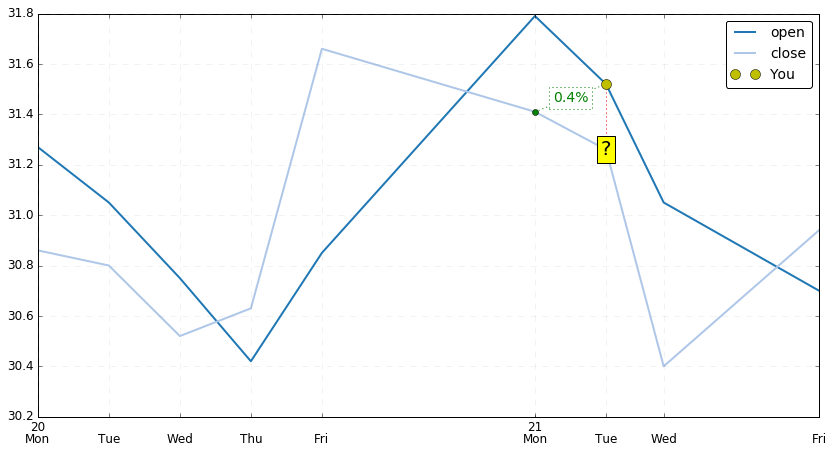

In [156]:
days = df_sel.shape[0]
print(days)
f, ax = plt.subplots(1,1)
df_sel[['open','close']].plot(lw=2,ax=ax)
d_day = 6
HIST = True
PRED = True
if HIST:
    for i in np.arange(d_day-1,d_day):
        x1 = df_sel.index[i]; x2 = df_sel.index[i+1]
        print(x1,x2)
        df_sel.pipe(add_measurement,x=[x1,x2],m=['close','open'],ax=ax,color='y',text=True)
        #x1 = df_sel.index[i]; x2 = df_sel.index[i]
        #df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='y',text=True)
if PRED:
    for i in np.arange(d_day,d_day+1):
        x1 = df_sel.index[d_day]; x2 = df_sel.index[i]
        df_sel.pipe(add_measurement,x=[x1,x2],m=['open','close'],ax=ax,color='orange')

# YOU
df_sel.iloc[[d_day]]['open'].rename('You').plot(marker='o', linestyle='none', color='y',ax=ax, legend=True ,
                                                ms=10,alpha=1,lw=1)
# QUESTIONMARK
offset = 0
ax.text(x=df_sel.index[d_day+offset], y=df_sel.loc[df_sel.index[d_day+offset]]['close'], s='?',size=20,ha="center",
        va="center", bbox=dict(facecolor='yellow',ls='-'))

set_daily_xticks(df_sel,ax)
print(df_sel.iloc[[d_day]]['open'].rename('You'))
#f.savefig('fig/'+stock+'-'+str(days)+'-hist-'+str(HIST)+'-pred-'+str(PRED)+'.png', dpi=100,bbox_inches='tight')

### Correlation

In [25]:
#CHECK CORRELATION BETWEEN MEASURES
import seaborn as sns

corr_var = [x for x in np.unique(df_stock.columns.get_level_values(level=0)) if 'x-' in x or 'y-' in x]
print(corr_var)
for stock in stocks:
    f, ax = plt.subplots(1,1)
    corr = df_stock_swap[stock][corr_var].corr()
    sns.heatmap(corr,square=True, ax=ax)
    ax.set_title(stock)
    f.savefig(stock+'.png', dpi=100,bbox_inches='tight')

ImportError: No module named 'seaborn'

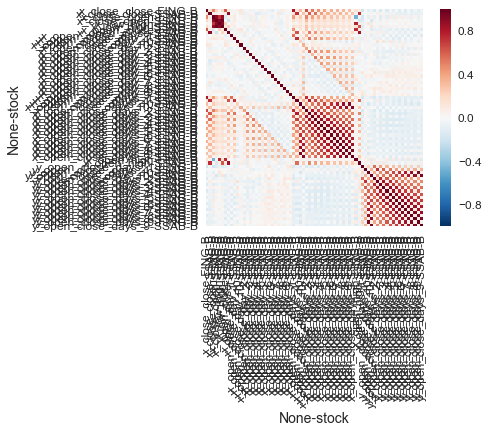

In [125]:
#CHECK CORRELATION BETWEEN MEASURES AND STOCKS!
import seaborn as sns

f, ax = plt.subplots(1,1)

corr = df_stock[corr_var].corr()
sns.heatmap(corr,square=True, ax=ax)

### What happened x days after a decline?

(-10, 10)

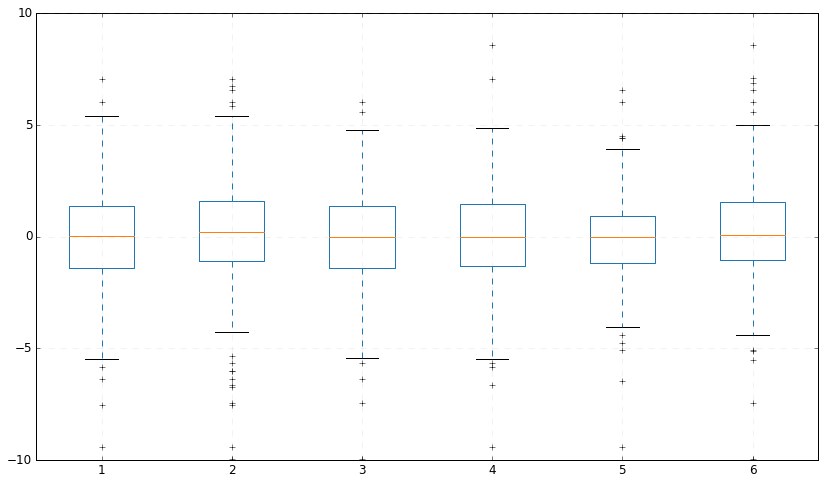

In [32]:
# DAY
f, ax = plt.subplots(1,1)
x_days = 1
pct_change = -2
df_days = []
for x_days in [1,2,3,4,5,6]:
    df_temp = (
        df_stock['x-close-close'][(df_stock['x-close-close']<pct_change).shift(x_days).replace(np.nan,False)]
        .stack().rename(str(x_days)).reset_index()[str(x_days)]
    )
    df_days.append(df_temp)
df_days = pd.concat(df_days,axis=1)
df_days.plot(kind='box', grid=True, ax=ax)
ax.set_ylim([-10,10])

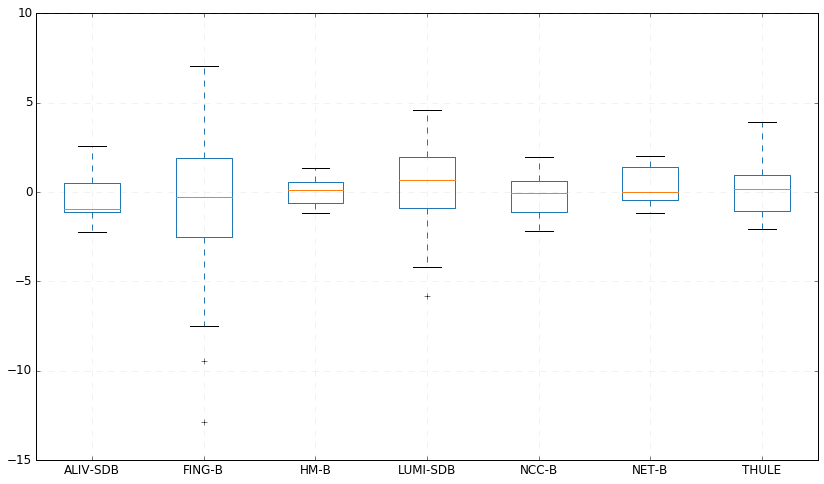

In [34]:
# STOCK
x_days = 1
df_stock['x-close-close'][(df_stock['x-close-close']<pct_change).shift(x_days).replace(np.nan,False)].plot(kind='box',grid=True)

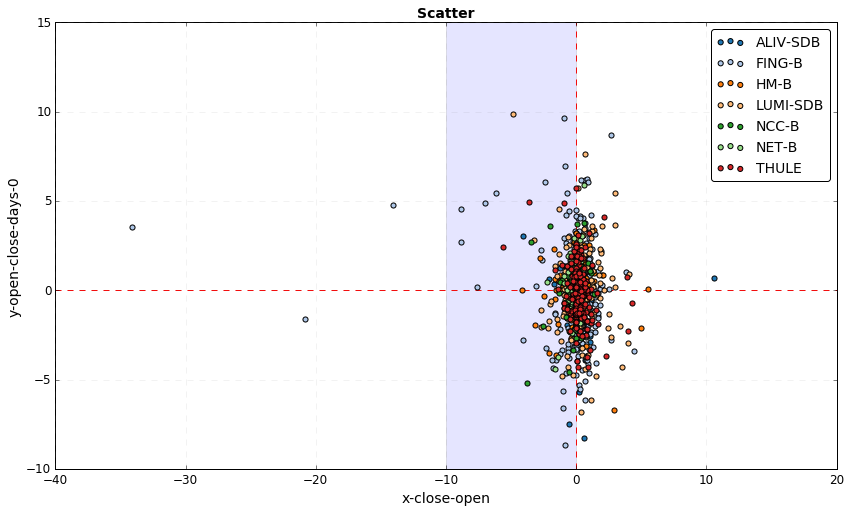

In [129]:
#df_stock_swap = df_stock.swaplevel(axis=1)

# Close price change dependancy
f, ax = plt.subplots(1,1)
x = 'x-close-open'
y = 'y-open-close-days-0'
#for days in []
for nr,stock in enumerate(stocks):
    #print(stock)
    df_sel = df_stock_swap[stock]
    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
    df_sel.plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=26,color=tableau20[nr],legend=True,zorder=3)
ax.legend(stocks)
ax.set_title('Scatter')
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')
#ax.set_xlim([-10,10])
#plt.axvline(-1,ls='--',color='r')
ax.axvspan(xmin=-10,xmax=0,alpha = 0.1,zorder=1)

In [ ]:
#df_stock_swap = df_stock.swaplevel(axis=1)

# Close price change dependancy
f, ax = plt.subplots(1,1)
x = 'x-close-open'

y = 'y-open-close-days-0'
for days in np.arange(1,11):
    x = 'x-open-open-days-'+str(days)
    for nr,stock in enumerate(stocks):
        #print(stock)
        df_sel = df_stock_swap[stock]
        #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
        #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
        df_sel.plot(ax=ax,kind='scatter',x=x,y=y,grid=True,s=26,color=tableau20[nr],title=x+' | '+y,legend=True,zorder=3)
    ax.legend(stocks)
ax.axhline(0,ls = '--',color='red')
ax.axvline(0,ls = '--',color='red')
#ax.set_xlim([-10,10])
#plt.axvline(-1,ls='--',color='r')
#ax.axvspan(xmin=-10,xmax=-1,alpha = 0.1,zorder=1)

In [47]:
test

datetime
2016-10-11 17:30:00   -0.055249
2016-10-13 17:30:00   -1.053215
2016-10-14 17:30:00    0.282008
2016-10-17 17:30:00    0.056561
2016-10-18 17:30:00   -0.736544
2016-10-28 17:30:00   -1.023891
2016-11-02 17:30:00    0.409836
2016-11-03 17:30:00    1.112412
2016-11-04 13:00:00   -1.162791
2016-11-09 17:30:00    3.017502
2016-11-11 17:30:00    0.803674
2016-11-15 17:30:00    0.280741
2016-11-21 17:30:00    0.055127
2016-11-28 17:30:00    0.158730
2016-12-01 17:30:00    1.358412
2016-12-05 17:30:00    0.740741
2016-12-12 17:30:00   -0.298211
2016-12-15 17:30:00    1.485149
2016-12-16 17:30:00    0.589391
2016-12-19 17:30:00   -0.783546
2016-12-22 17:30:00   -0.961538
2016-12-23 17:30:00   -0.291829
2016-12-28 17:30:00    0.386100
2016-12-29 17:30:00    0.483092
2016-12-30 17:30:00   -1.058710
2017-01-04 17:30:00   -0.862069
2017-01-05 13:00:00    0.290135
2017-01-09 17:30:00   -1.553398
2017-01-10 17:30:00    0.592300
2017-01-12 17:30:00   -1.947420
                         ...   